In [1]:
using Plots
using Random
using Distributions
using LinearAlgebra
#include("pogm_restart.jl") # issues adding MIRT so will use julia file instead
N = 500 # total points
D = 100 # ambient space
d = 10 # subspace rank
σ1 = 0.5 # noise level 1
σ2 = 10 # noise level 2
goodpts = 10 # good points out of total
window = 33 # size of range for coordinate data
X = zeros(D,N)
Y = zeros(D,N)
Π = vec(zeros(N,1))
U1 = svd(rand(D,N)).U[:,1:d]
for k = 1:N
    # older code projecting points U1*U1'*rand(Uniform(-100,100),D)
    X[:,k] =  U1*rand(Uniform(-33,33),d) 
    #X[:,k] =  U1*rand(Normal(0,19.05),d)
end
for j=1:N
        if (j<= goodpts)
            Y[:,j] = X[:,j] + rand(Normal(0,σ1),D)
            Π[j] = σ1^2
        else
            Y[:,j] = X[:,j] + rand(Normal(0,σ2),D)
            Π[j] = σ2^2
        end
end

In [2]:
XL = []
YL = []
for i = 1:25
    rng = Random.seed!(i)
    X0 = zeros(D,N)
    Y0 = zeros(D,N)
    for k = 1:N
    # older code projecting points U1*U1'*rand(Uniform(-100,100),D)
        X0[:,k] =  U1*rand(Uniform(-33,33),d) 
        #X0[:,k] =  U1*rand(Normal(0,19.05),d)
    end
    push!(XL,X0)
    for j=1:N
        if (j<= goodpts)
            Y0[:,j] = X0[:,j] + rand(Normal(0,σ1),D)
        else
            Y0[:,j] = X0[:,j] + rand(Normal(0,σ2),D)
        end
    end
    push!(YL,Y0)
end

In [3]:
function weightedPCA(Y , w, k)
    L = unique(w)
    Σ = zeros(size(Y)[1], size(Y)[1])
    for i=1:length(L)
        ind = findall(x -> x == L[i], w)
        Σ = Σ + L[i]*(Y[:,ind]*Y[:,ind]')
    end
    U = reverse(eigvecs(Σ), dims=2)
    Ȳ = reshape(shuffle(Y[:]), size(Y))
    U_Y = svd(Y).S
    U_Ȳ = svd(Ȳ).S
    #k = floor(Int, norm(U_Y .> U_Ȳ, 0))
    return U[:,1:k] #, k
end
U_WPCA = weightedPCA(Y,Π.^-1,d);

In [4]:
using HePPCAT
heppCAT_matrix = []
push!(heppCAT_matrix, Y[:,1:goodpts])
push!(heppCAT_matrix, Y[:,(goodpts+1):end])
heppCAT_nogroups = []
for i = 1:N
    push!(heppCAT_nogroups, Y[:,i])
end
homoPCA = heppcat(heppCAT_matrix,d,0)   # init is homoscedastic PPCA
heppCAT = heppcat(heppCAT_matrix,d,1000;varfloor=1e-9)  
heppCAT_NOG = heppcat(heppCAT_nogroups,d,1000;varfloor=1e-9)
error_heppcat = norm(heppCAT.U*heppCAT.U' - U1*U1', 2)/norm(U1*U1', 2)
error_heppcat_NOG = norm(heppCAT_NOG.U*heppCAT_NOG.U' - U1*U1', 2)/norm(U1*U1', 2)
error_homoppca = norm(homoPCA.U*homoPCA.U' - U1*U1', 2)/norm(U1*U1', 2)
error_wpca = norm(U_WPCA*U_WPCA' - U1*U1', 2)/norm(U1*U1', 2)

0.17859712697741012

In [5]:
error_homoppca

0.35369680973547757

In [6]:
error_heppcat

0.20771124704732502

In [7]:
error_heppcat_NOG

0.24070577301708868

In [8]:
colors = theme_palette(:auto).colors

In [9]:
function HPCA_KNOWN_ADMM(Y, λr, w, N, μ, ρ)
    X = zeros(size(Y))
    Z = zeros(size(Y))
    Z = deepcopy(Y-X)
    Π = Diagonal(w.^-1)
    Λ2 = sign.(Y)
    Λ = deepcopy(Λ2 ./ (max(opnorm(Λ2), (1/λr)*norm(Λ2, Inf))))
    normY = norm(Y,2)
    count = 0
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,N)
        U,S,V = svd(x)
        S[(N+1):end] = soft.(S[(N+1):end],t)
        return U*diagm(S)*V'
    end
    while ((norm(Y-X-Z,2)/normY > 1e-6) || (count <100))
        X = pssvt(Y-Z+(1/μ)*Λ, λr/μ,N)
        Z = μ*(Y-X+(1/μ)*Λ)*inv(Π+μ*I)
        Λ = Λ + μ*(Y-X-Z)
        μ = ρ*μ
        count = count + 1
    end
    U = svd(X).U[:,1:10]   
    return U
end

HPCA_KNOWN_ADMM (generic function with 1 method)

In [10]:
U_HPCA = HPCA_KNOWN_ADMM(Y, 50, Π, 10, 0.01, 1.01)
norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)

0.178598145764655

In [11]:
wpca_list_known = []
heppcat_list_known = []
homopca_list_known = []
hpca_list_known = []
hpca_nuclear_known = []
λr = vcat(0:0.8:20)
λr2 = vcat(0:0.2:5)
for i=1:25
    println(i)
    flush(stdout)
    homoPCA_U = svd(YL[i]).U[:,1:10]
    errorPCA = norm(homoPCA_U*homoPCA_U' - U1*U1',2)/norm(U1*U1',2)
    push!(homopca_list_known, errorPCA)
    U_WPCA = weightedPCA(YL[i],Π.^-1,d);
    errorWPCA = norm(U_WPCA*U_WPCA' - U1*U1',2)/norm(U1*U1',2)
    push!(wpca_list_known, errorWPCA)
    
    heppCAT_matrix = []
    T = YL[i]
    push!(heppCAT_matrix, T[:,1:goodpts])
    push!(heppCAT_matrix, T[:,(goodpts+1):end])
    homoPCA = heppcat(heppCAT_matrix,d,0)   # init is homoscedastic PPCA
    knownvar = deepcopy(homoPCA)
    knownvar.v[1] = σ1^2
    knownvar.v[2] = σ2^2
    heppCAT_known = heppcat(heppCAT_matrix,d,1000;init=knownvar,vknown=true,varfloor=1e-9);
    error_heppcat = norm(heppCAT_known.U*heppCAT_known.U' - U1*U1', 2)/norm(U1*U1', 2)
    push!(heppcat_list_known, error_heppcat)
    
    error_hpca_known = zeros(size(λr))
    error_hpca_nuclear = zeros(size(λr))
    for j=1:length(λr)
        U_HPCA = HPCA_KNOWN_ADMM(YL[i], λr[j], Π, 10, 0.01, 1.01)  
        error_hpca_known[j] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
        U_HPCA = HPCA_KNOWN_ADMM(YL[i], λr2[j], Π, 0, 0.01, 1.01)  
        error_hpca_nuclear[j] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
    end
    push!(hpca_list_known, error_hpca_known)
    push!(hpca_nuclear_known, error_hpca_nuclear)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [26]:
include("/home/javier/Desktop/alpcah/alpcah.jl");
hpca_lr_known = []
for i=1:25
    test_U = ALPCAH_KNOWN_ALTMIN(YL[i], 10, Π; alpcahIter=100)
    errortest = norm(test_U*test_U' - U1*U1',2)/norm(U1*U1',2)
    push!(hpca_lr_known, errortest)
end

In [27]:
heppcat_mean = mean(heppcat_list_known);
homopca_mean = mean(homopca_list_known)
wpca_mean = mean(wpca_list_known);
hpca_mean = mean(hpca_list_known);
hpca_lr_mean = mean(hpca_lr_known);
hpca_mean_nuclear = mean(hpca_nuclear_known);

In [28]:
heppcat_std = std(heppcat_list_known);
homopca_std = std(homopca_list_known)
wpca_std = std(wpca_list_known);
hpca_std = std(hpca_list_known);
hpca_lr_std = std(hpca_lr_known);
hpca_std_nuclear = std(hpca_nuclear_known);

In [34]:
colors = theme_palette(:auto).colors

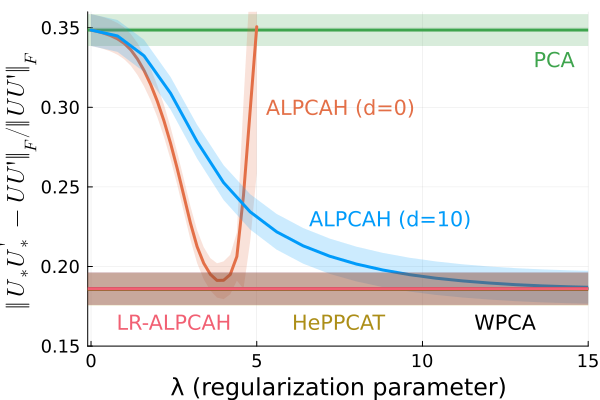

In [80]:
using LaTeXStrings
λr = vcat(0:0.8:20)
λr2 = vcat(0:0.2:5)
plot(xlabel="λ (regularization parameter)",ylims=(0.15,0.36),xlims=(-0.1,15),ylabel=L"\Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F")
plot!(legend_position=:right, legendfontpointsize=12,xtickfontsize=12,ytickfontsize=12,guidefontsize=16,titlefontsize=18, legend=:false)
hline!([homopca_mean],ribbon=homopca_std,c=colors[3], fillalpha = 0.2,linewidth=3, label="PCA")
plot!(λr2,hpca_mean_nuclear, ribbon=hpca_std_nuclear, fillalpha = 0.2, c=colors[2], linewidth=3, label="ALPCAH")
plot!(λr,hpca_mean, ribbon=hpca_std, fillalpha = 0.2, c=colors[1], linewidth=3, label="ALPCAH")
hline!([heppcat_mean],ribbon=heppcat_std, c=colors[5], fillalpha = 0.2, linewidth=3, label="HePPCAT")
hline!([wpca_mean],ribbon=wpca_std, c=:black, linewidth=3,fillalpha = 0.2, label="WPCA")
hline!([hpca_lr_mean],ribbon=hpca_lr_std, c=colors[end-2], linewidth=3,fillalpha = 0.2, label="LR-ALPCAH")

annotate!(14, 0.33, "PCA", colors[3])
annotate!(7.5, 0.165, "HePPCAT", colors[5])
annotate!(9, 0.23, "ALPCAH (d=10)", colors[1])
annotate!(7.5, 0.30, "ALPCAH (d=0)", colors[2])
annotate!(12.5, 0.165, "WPCA", :black)
annotate!(2.5, 0.165, "LR-ALPCAH", colors[end-2])
#savefig("alpcah_absolute_error_known.pdf")